In [1]:
import os
import pandas as pd
import numpy as np

import wrangle as wr
import explore as ex
import model as md

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE, SelectKBest, f_regression

from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

# What is driving the errors in the Zestimate?

<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px"></hr>

# Project Goals
- The goal of this project is to identify key drivers of logerror in the Zillow property value estimates and come up with a model for predicting the logerror.

# Project Description
- This project runs through the entire Data Science Pipeline using various methodoligies such as regression and clustering to assist in completing our project goal of predicting logerror.

<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px"></hr>

# Project Planning

- Create README.md with data dictionary, project and business goals, and come up with initial hypotheses.

- Acquire data from the Codeup Database and create a function to automate this process. 
- Clean and prepare data for the first iteration through the pipeline, MVP preparation. Create a function to automate the process. 
- Store the acquisition and preparation functions in a wrangle.py module function, and prepare data in Final Report Notebook by importing and using the function.
- Clearly define at least two hypotheses, set an alpha, run the statistical tests needed, reject or fail to reject the Null Hypothesis, and document findings and takeaways.
- Establish a baseline accuracy and document well.
- Train at least 3 different regression models.
- Evaluate models on train and validate datasets.
- Choose the model that performs the best and evaluate that single model on the test dataset.
- Document conclusions, takeaways, and next steps in the Final Report Notebook.

<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px"></hr>

# Data Wrangling/Train, Validate, Test

<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px"></hr>

In [2]:
# Obtaining data from the CodeUP database through a SQL query that can be found in wrangle.py
df = wr.get_zillow()
df.shape

(52319, 68)

In [3]:
# Splitting the dataframe into 3 seperate samples to prevent data leakage
train, validate, test = wr.wrangle_zillow()
train.shape, validate.shape, test.shape

((24431, 35), (10471, 35), (8726, 35))

##  Wrangling Takeaways
- We started off by pulling a SQL query for Single Family homes sold in 2017. 
- Approximately 52,000 observations were recieved from the CodeUP database using SQL.
- Following the Data Acquisition the following preparation work was done to the acquired data:
   - Removed columns and rows that were missing more than 50% of their data so as to ensure observations were suitable for this project.
   - Following data prepartion we were left with a dataframe consisting of 43,628 observations.
   - Split data into 3 datasets, train, validate and test.

# Intial Questions
- Does the county a property is located in affect it's log error?
- Does the tax variables of a house affect the logerror?
- Does the ratio of home sqft to lot sqft affect logerror?
- Does the year a house was built affect logerror?

<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px"></hr>

# Data Exploration

- Prior to modeling we have asked a few questions of the data and have used clustering to help in exploration.


## 1. Does the county a property is located in affect it's log error?

Here is show the logerror of the entire map of all 3 counties.


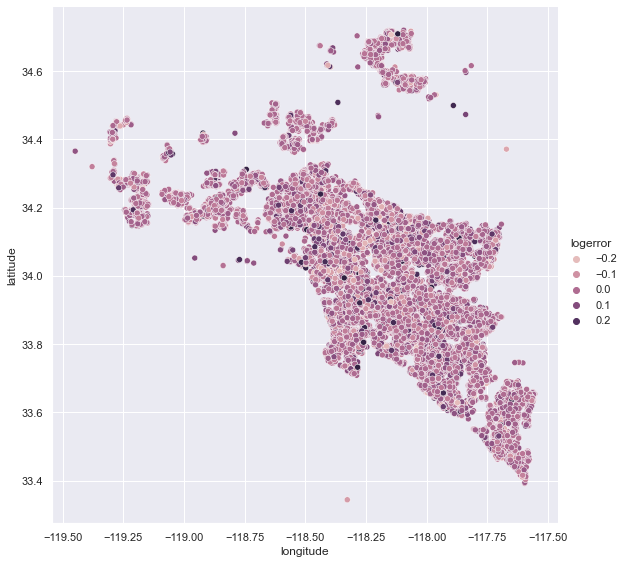

Here is shown all three counties split up for better visability.


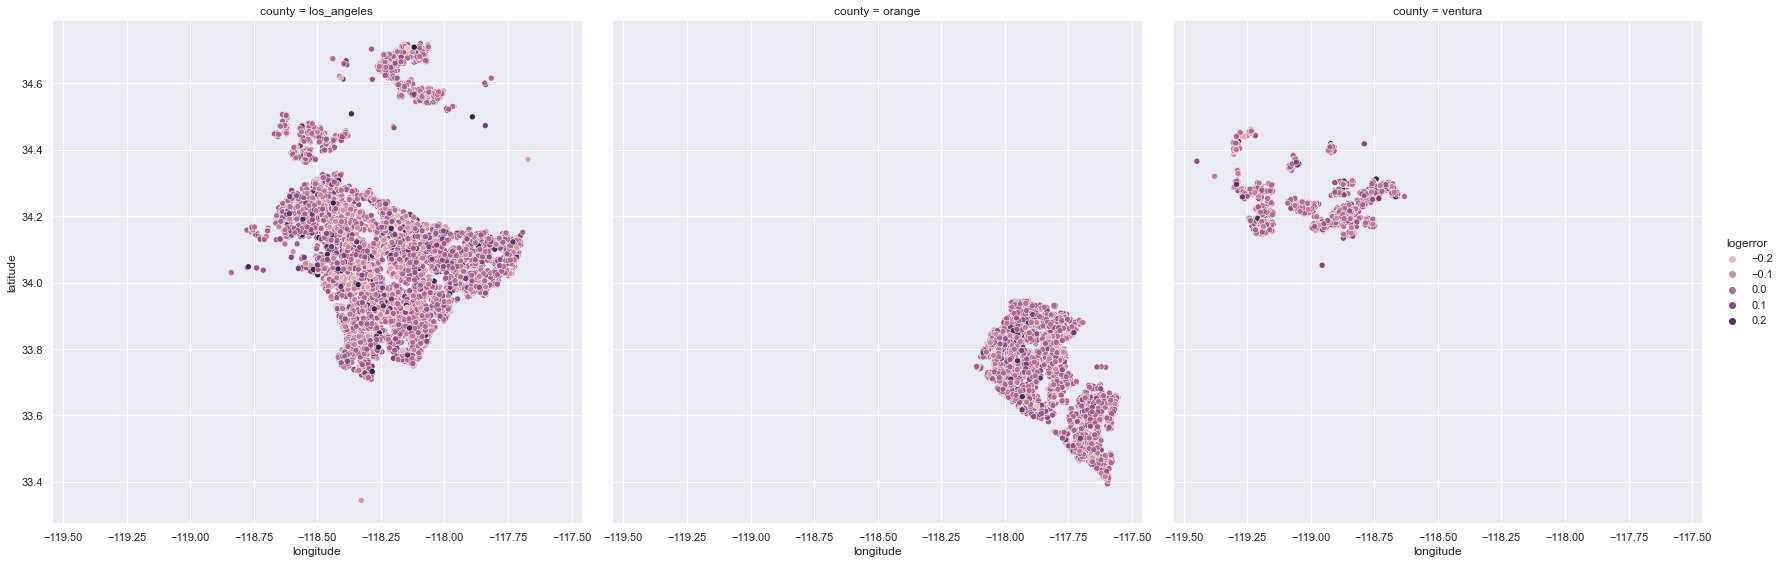

In [4]:
# Function will return a graph showing logerror differences between the 
# 3 counties Los Angeles, Ventura and Orange County
ex.countygraph(train)

#### Takeaways:
- For properties in ventura the logerror range seems to be lower than those in Orange county and Los Angeles.
- Let's see if statistical can help that statement.

#### County statistical testing
(H_0): No difference in logerror between homes in ventura and homes not in ventura.

(H_a): There is a difference in logerror between homes in ventura and homes not in ventura.

In [5]:
# Statistical test that will look for a difference in logerror for homes 
# located in VENTURA and homes not in VENTURA
ex.ventura_test(train)

Fail to reject the Null Hypothesis.
        
No difference in logerror between homes in ventura and homes not in ventura.


<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px"></hr>

## 2. Does the tax variables of a house affect the logerror?
- For this, a cluster was created using tax_value, stucturetaxvaluedollarcnt, and landtaxvaluedollarcnt.

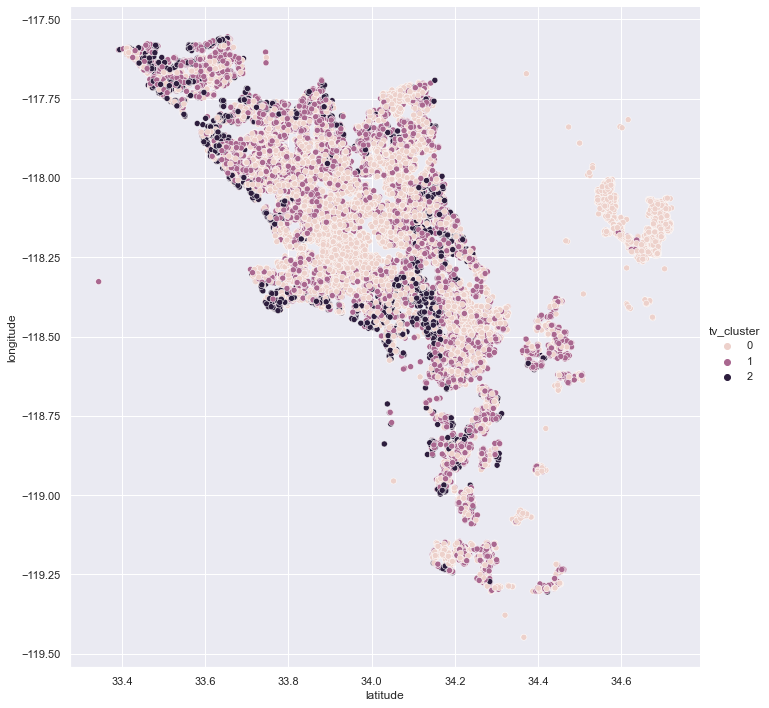

In [6]:
# Returns a graph split into 3 parts that show the 3 clusters created
# Was split for better visability
ex.tv_graph(train)

#### Takeaways
- From visualization it seems that  there does not seem to be a relationship between tax variables and logerror.
- Let's see if statistical can help that statement.

#### Tax_value testing
(H_0): There IS NOT a relationship between our value cluster and logerror. 

(H_a): There IS a relationship between value cluster and logerror.

In [7]:
# Performs statistical testing and looks for a relationship 
# between our tax cluster created and logerror
ex.tax_corr_test(train)

Reject the Null Hypothesis.
        
There IS a relationship between value cluster and logerror.


<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px"></hr>

## 3. Does the ratio of home sqft to lot sqft affect logerror?

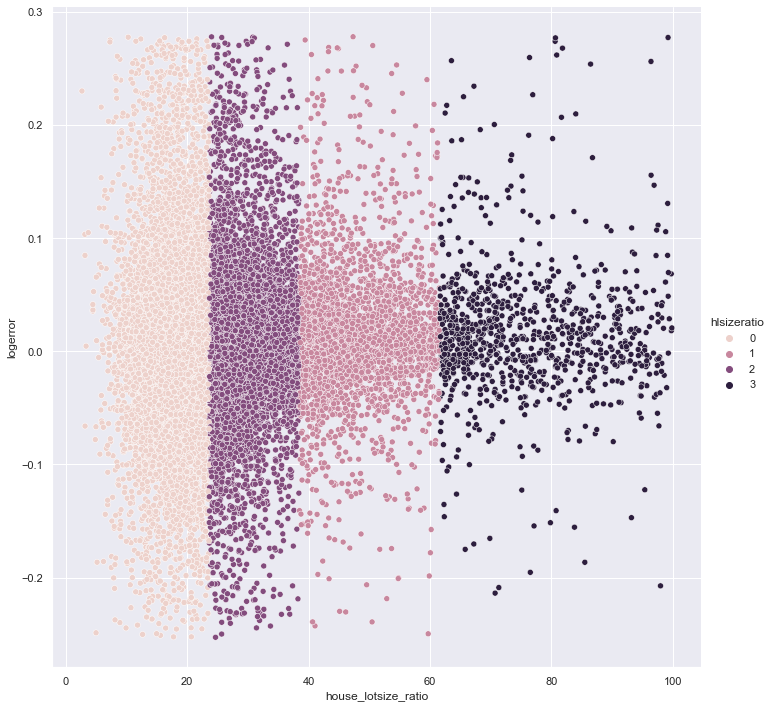

In [8]:
# Returns a graph showing our created ratio variable and its relationship to logerror
# split by clusters to look for any useful information
ex.htls_graph(train)

## Takeaways
- In this visual the clusters are not very helpful in that it just seems to split the data every 20 percent.
- It seems visually that once a home takes up more than 60 percent of the lotsize log error becomes closer to 0.
- Let's see if statistical can help that statement.


### House to lotsize ratio
H_0: Homes with a more than 60 percent house to lot ratio DO NOT have a logerror closer to 0.

H_a: Homes with a more than 60 percent house to lot ratio DO have a logerror closer to 0.

In [9]:
# Returns statistical test that looks to see if homes with a below
# 60 percent house sqft to lot sqft ratio have a lower logerror.
ex.sqft_lsize_ttest(train)

Fail to reject the Null Hypothesis.
        
Homes with a more than 60 percent house to lot ratio DO NOT have a lower logerror.


<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px"></hr>

## 4. Does the year a house was built affect logerror?

<Figure size 1008x576 with 0 Axes>

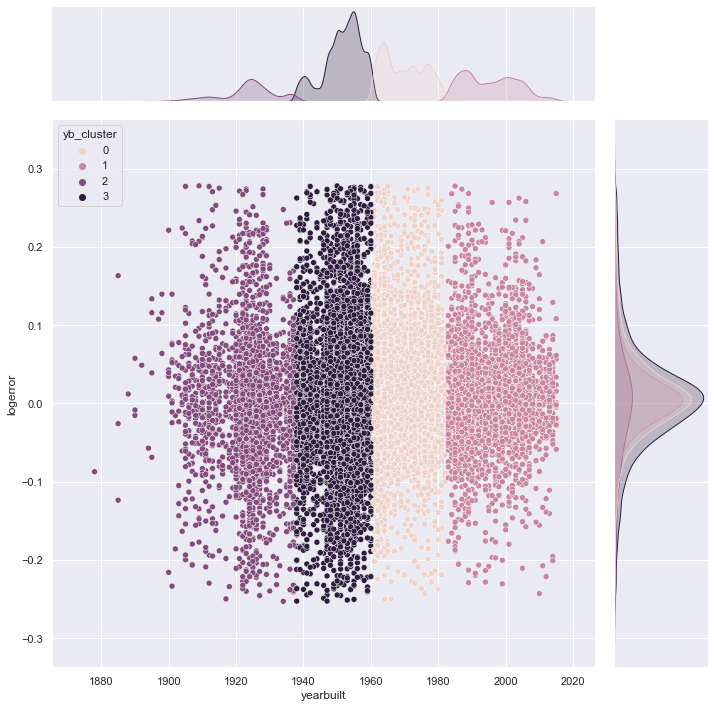

In [10]:
# Returns a graph that shows the relationship between the year a home was built and the logerror
# clustering was used to look for useful information.
ex.yb_graph(train)

### Takeaways
- Again here the clusters are not very useful.
- However it seems homes built after 2010 seem to have a logerror closer to 0.
- Lets see if this is true through statistical testing

#### Homes before 2010 vs homes after 2010 logerror difference.
(H_0): Homes built before 2010 DO NOT have a logerror closer to 0.

(H_a): Homes built before 2010 DO have a logerror cloeser to 0.

In [11]:
# Returns statistical test that looks to see if homes built after 2010
# have a logerror
ex.yb_test(train)

Fail to reject the Null Hypothesis.
        
Homes built before 2010 DO NOT have a logerror closer to 0.


## Exploration Summary


- We chose features to investigate, and created clusters for those selected features to see if they could assist in finding drivers for logerror. Of all the features selected only the tax variables showed a relationship towards logerror.

- Whatever the case we will take these features into modeling and see if they assist in improving logerror prediction.

<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px"></hr>

## Modeling 



#### - We will now go through using the features we investigated to see how they do with modeling.
#### - Prior to modeling let's scale our data with the investigated features to better acclimate them for modeling.

In [12]:
# Returns scaled versions of our dataframes using the features investigated earlier on the project.
X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test = md.scale_data_xy_split()

In [13]:
# Runs several models for both the train and validate samples and returns the results in a clean dataframe.
md.run_da_stuff(X_train_scaled,y_train,X_validate_scaled,y_validate)

,model,rmse_train,r2_train,rmse_validate,r2_validate
0,baseline_mean,0.066777,-2.220446e-16,0.066643,0.000000
1,Linear Regression,0.066685,2.778587e-03,0.066576,0.002010
2,"LarsLasso, alpha 1",0.066777,0.000000e+00,0.066643,0.000000
3,Tweedie Regressor,0.066684,2.805690e-03,0.066579,0.001911
4,"Polynomial Features, D2",0.066526,7.500065e-03,0.066550,0.002792
5,"Polynomial Features, D3",0.066467,9.287360e-03,0.066583,0.001792


#### - Of all models chosen the best performing model was the Polynomial Features with a Degree = 3, beating baseline in both train and validate tests.

#### - Now lets use this to test on our test dataset.

In [14]:
# Using our best performing model, returna dataframe that shows how the model 
# performed on all 3 samples of data as well as how the baseline model compares.
md.test_tester(X_train_scaled,y_train,X_validate_scaled,y_validate,X_test_scaled,y_test)

,rmse,r2
baseline,0.066777,0.009287
train,0.066467,0.009287
validate,0.066583,0.001792
test,0.068054,0.001214


## Modeling takeaways

- The Polynomial Features Degrees = 3 model peformed the best out of all 4 models tested for both train and validate datasets. 

- However did not outperform baseline on the test dataset. Further research will need to be done to improve these models.


<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px"></hr>

# Conclusions, Reccomendations and Next Steps

- Of the features we investigated, the tax variable features and location features showed a relationship towards logerror.

- With the housing market being so volatile and prone to being affected by outside forces it can be hard to predict both pricing and improve logerror.

- We believe that this dataset is simply too large and perhaps focusing in on smaller areas may provide some benefits.

- With that said our final conclusion is that the features elected for our model are not ones to be utilized and further research will need to be done to improve the logerror.

- Next steps after this project may be to choose different features and focus in on smaller areas with the 3 counties.

<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px"></hr>